In [23]:
import os # os functionalities
import random # generation of random numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from sklearn import metrics # create ROC curve
from matplotlib import pyplot as plt # image visualization

# Tensorflow & Keras
import warnings
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

# Image manipulation
from skimage import io
from PIL import Image, ImageOps
from IPython.display import Image, display

In [24]:
# Variable declaration
input_dir = r"C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\train3"
target_dir = r"C:\Users\arunm\thusharproj\test\final_pseudo_labels2"

epochs = 25
batch_size = 16
img_size = (160,160)
learning_rate = 0.001
optimizer = "RMSprop"
data_augmentation = False
loss_function = "sparse_categorical_crossentropy"
num_classes = 2 # 0 - 1 / lesion - no lesion

# Percentages of images going to train - val - test sets
percentage_test = 0.05
percentage_validation = 0.12

In [25]:
input_dir

'C:\\Users\\arunm\\thusharproj\\test\\2018LA_Seg_Training Set\\images\\train3'

In [26]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 363
Number of samples in the target set: 363


The shape of the pictures in the training set is: (768, 1024, 3)
The shape of the pictures in the target set is: (160, 160)


Text(0.5, 1.0, 'Segmentation mask')

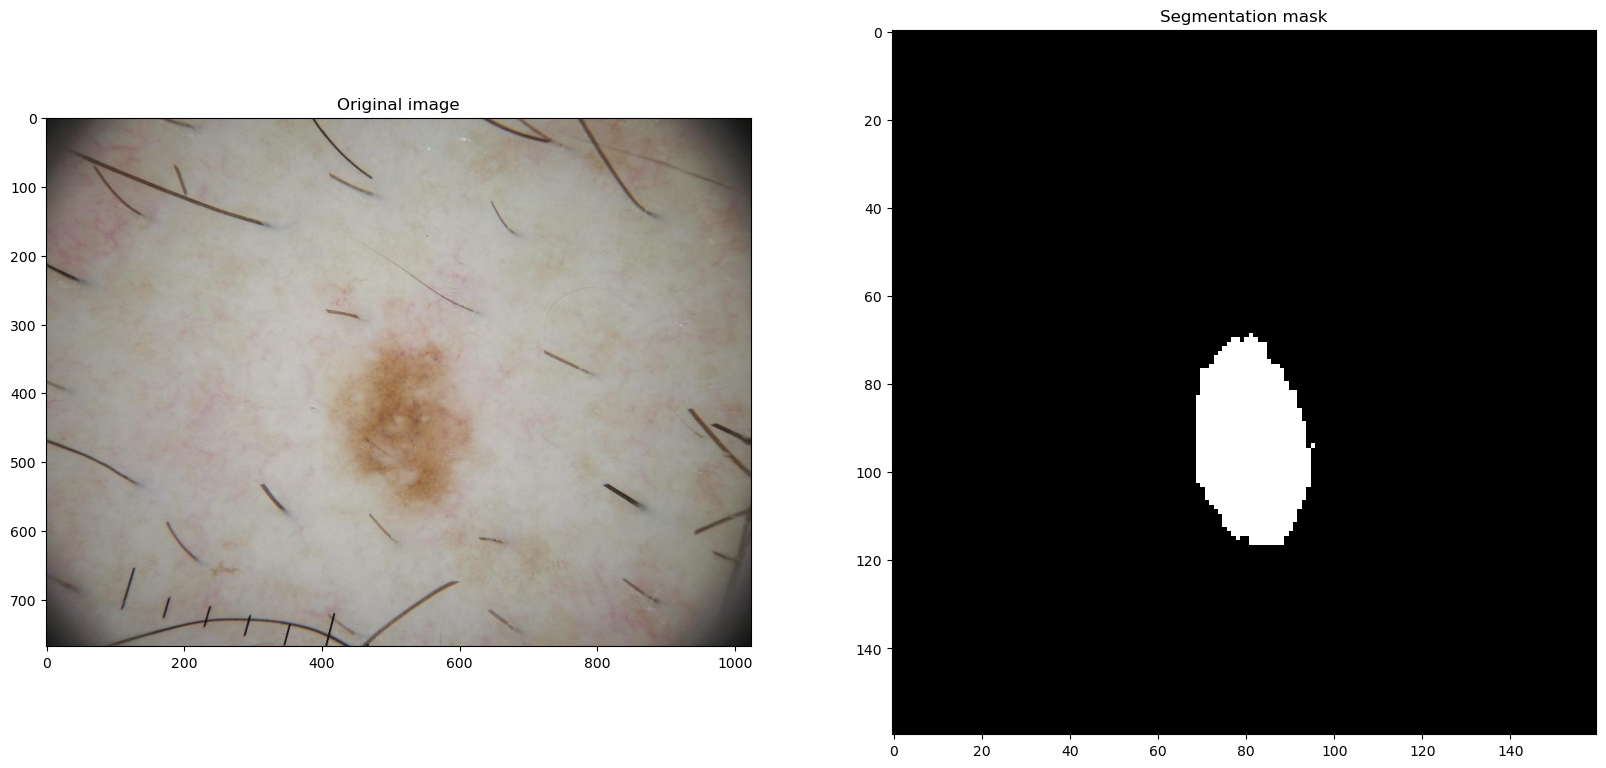

In [27]:
# Read training images and get their shape
image_to_visualize = 350
img1 = io.imread(input_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = io.imread(target_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")

# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(target_img_paths[image_to_visualize]), cmap='gray')
plt.title("Segmentation mask")

In [28]:
class LesionSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, data_augmentation):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
    
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        if self.data_augmentation:
            x = np.zeros((self.batch_size * 2,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size * 2,) + self.img_size + (1,), dtype="uint8")
            
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                img_target2 = load_img(batch_target_img_paths[j], target_size=self.img_size)
                
                # Convert PIL Images to NumPy arrays
                img_array = np.array(img)
                img_target_array = np.array(img_target)
                img_target2_array = np.array(img_target2)
                
                # Apply data augmentation
                img_augmented, img_target_augmented = self.generate_data_augmentation(img_array, img_target2_array)
                
                # Normalize and assign images
                x[j] = tf.cast(img_array, tf.float32) / 255.0
                y[j] = (np.expand_dims(img_target_array, 2) / 255).astype(int)
                x[self.batch_size + j] = tf.cast(img_augmented, tf.float32) / 255.0
                
                # Convert augmented target to grayscale if necessary and assign
                img_target_augmented = tf.image.rgb_to_grayscale(img_target_augmented)
                y[self.batch_size + j] = (img_target_augmented.numpy() / 255).astype(int)
        
        else:
            x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
            y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
            
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size)
                img_target = load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
                
                # Convert PIL Images to NumPy arrays
                img_array = np.array(img)
                img_target_array = np.array(img_target)
                
                # Normalize and assign images
                x[j] = tf.cast(img_array, tf.float32) / 255.0
                y[j] = (np.expand_dims(img_target_array, 2) / 255).astype(int)
        
        return x, y

    
    
    def generate_data_augmentation(self, img_orig, mask_orig):
        """Custom data augmentation function whose purpose is to generate new images by modifying the images already 
        present in the dataset. The fact that the function is custom respons to the imposibility of finding an adequate
        utility in Tensorflow for this pupose that is able to modify both the images and the segmentations in the same way."""
        
        # Zoom
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.central_crop(img_orig, 0.75)
            mask_orig = tf.image.central_crop(mask_orig, 0.75)
            img_orig = tf.image.resize(img_orig, self.img_size)
            mask_orig = tf.image.resize(mask_orig, self.img_size)

        # Random brightness adjustment illumination
        img_orig = tf.image.random_brightness(img_orig, 0.3)
        
        # Random contrast adjustment
        img_orig = tf.image.random_contrast(img_orig, 0.2, 0.5)

        # Flipping random horizontal or vertical
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_left_right(img_orig)
            input_mask = tf.image.flip_left_right(mask_orig)
        if tf.random.uniform(()) > 0.5:
            img_orig = tf.image.flip_up_down(img_orig)
            input_mask = tf.image.flip_up_down(mask_orig)

        # Rotation in 30° steps
        rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
        angle = np.pi/12*rot_factor
        img_orig = tfa.image.rotate(img_orig, angle)
        mask_orig = tfa.image.rotate(mask_orig, angle)
        
        return img_orig, mask_orig

In [29]:
# Split our img paths into a training validation and test sets
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

test_samples = int(len(input_img_paths)*percentage_test)
train_input_img_paths = input_img_paths[:-test_samples]
train_target_img_paths = target_img_paths[:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_samples = int(len(train_input_img_paths)*percentage_validation)
val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

print(f"Samples in train: {len(train_input_img_paths)}")
print(f"Samples in validation: {len(val_input_img_paths)}")
print(f"Samples in test: {len(test_input_img_paths)}")

Samples in train: 304
Samples in validation: 41
Samples in test: 18


In [30]:
# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths, data_augmentation)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, False)

In [31]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
'''from tensorflow.keras.utils import plot_model

# Assuming 'model' is your U-Net model
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)'''

"from tensorflow.keras.utils import plot_model\n\n# Assuming 'model' is your U-Net model\nplot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)"

In [32]:
# Choose optimizer
if optimizer == "SGD": # SGD
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop": # RMSprop
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else:  # Adam
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8, amsgrad=True)

In [33]:
# Configure the model for training
model.compile(optimizer=fit_optimizer, loss=loss_function)

# Save the best model during training
callbacks = [keras.callbacks.ModelCheckpoint("pseudofinal_lesion_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Serialize and save the model architecture to JSON
model2_json = model.to_json()
with open("pseudofinal_model.json", "w") as json_file:
    json_file.write(model2_json)

# Serialize and save the model weights to HDF5
model.save_weights("pseudofinal_model.h5")
print("Saved model to disk")


Epoch 1/25
19/19 [==============================] - 34s 1s/step - loss: 1.1315 - val_loss: 0.4023
Epoch 2/25
19/19 [==============================] - 24s 1s/step - loss: 0.1930 - val_loss: 0.4481
Epoch 3/25
19/19 [==============================] - 21s 1s/step - loss: 0.2004 - val_loss: 0.7952
Epoch 4/25
19/19 [==============================] - 17s 914ms/step - loss: 0.1489 - val_loss: 0.5520
Epoch 5/25
19/19 [==============================] - 17s 911ms/step - loss: 0.1842 - val_loss: 0.7456
Epoch 6/25
19/19 [==============================] - 17s 918ms/step - loss: 0.1135 - val_loss: 2.2650
Epoch 7/25
19/19 [==============================] - 17s 907ms/step - loss: 0.1068 - val_loss: 0.8764
Epoch 8/25
19/19 [==============================] - 17s 915ms/step - loss: 0.0736 - val_loss: 0.7898
Epoch 9/25
19/19 [==============================] - 17s 903ms/step - loss: 0.1061 - val_loss: 1.0202
Epoch 10/25
19/19 [==============================] - 17s 906ms/step - loss: 0.0716 - val_loss: 0.896

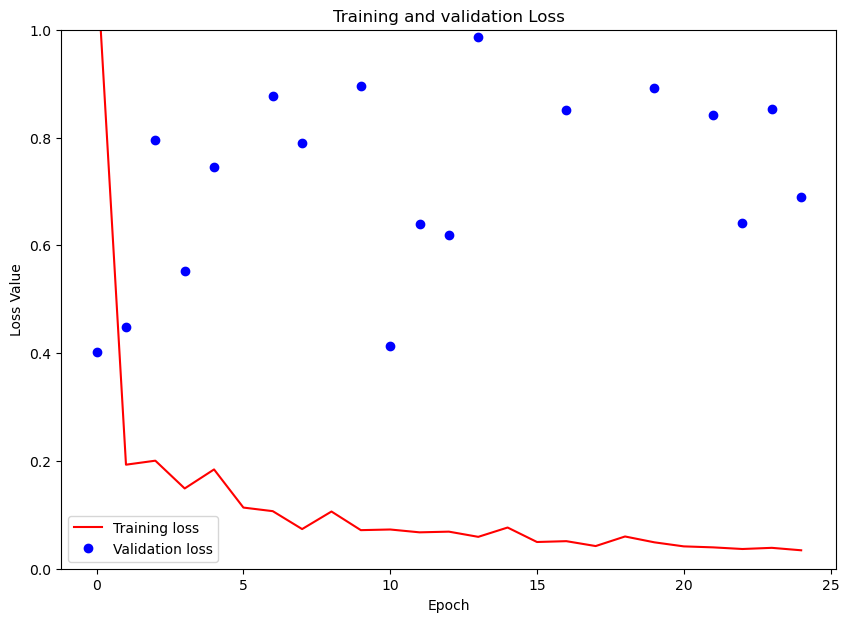

In [34]:
# Plot training and validation loss while training
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Training and validation loss.jpg', dpi=500)
plt.show()

In [43]:
test_gen = LesionSegmentation(batch_size, img_size, test_input_img_paths, test_target_img_paths, False)
test_preds = model.predict(test_gen)

jaccard_scores = []
dice_scores = []
pixel_accuracy = []
sensitivity = []
specificity = []

predictions_formatted = []
ground_truth_formatted = []

for i in range(0, len(test_preds)):
    # Adapt prediction and ground truth
    prediction = np.argmax(test_preds[i], axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    predictions_formatted.append(prediction.flatten())
    
    ground_truth = np.array(load_img(test_target_img_paths[i], target_size=img_size, color_mode="grayscale"))
    ground_truth = (np.expand_dims(ground_truth, 2) / 255).astype(int)
    ground_truth_formatted.append(ground_truth.flatten())
    
    number_of_pixels = img_size[0] * img_size[1]
    
    # Get Jaccard score (IoU)
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    
    if np.sum(union) == 0:  # Avoid division by zero
        jaccard_scores.append(1 if np.sum(ground_truth) == 0 and np.sum(prediction) == 0 else 0)
    else:
        jaccard_scores.append(np.sum(intersection) / np.sum(union))

    # Get Dice coefficient
    intersection = np.sum(np.logical_and(ground_truth.flatten(), prediction.flatten()))
    dice_scores.append((2 * intersection) / (np.sum(ground_truth) + np.sum(prediction)))
    
    # Pixel-based metrics
    equal_pixels = np.sum(ground_truth.flatten() == prediction.flatten())
    
    number_of_true_positives = np.sum((ground_truth.flatten() == 1) & (prediction.flatten() == 1))
    number_of_true_negatives = np.sum((ground_truth.flatten() == 0) & (prediction.flatten() == 0))
    number_of_false_positives = np.sum((ground_truth.flatten() == 0) & (prediction.flatten() == 1))
    number_of_false_negatives = np.sum((ground_truth.flatten() == 1) & (prediction.flatten() == 0))
    
    # Pixel accuracy: (Correct predictions / Total pixels)      
    pixel_accuracy.append(equal_pixels / number_of_pixels)
    
    # Sensitivity (Recall)
    try:
        sensitivity.append(number_of_true_positives / (number_of_true_positives + number_of_false_negatives))
    except ZeroDivisionError:
        sensitivity.append(0)
    
    # Specificity
    try:
        specificity.append(number_of_true_negatives / (number_of_true_negatives + number_of_false_positives))
    except ZeroDivisionError:
        specificity.append(0)

# Print the metrics
print(f"Jaccard Score: {np.mean(jaccard_scores)} \nDice Score: {np.mean(dice_scores)} \nPixel accuracy: {np.mean(pixel_accuracy)} \nSensitivity: {np.mean(sensitivity)} \nSpecificity: {np.mean(specificity)}")


1/1 [==============================] - 1s 568ms/step
Jaccard Score: 0.2533831643918837 
Dice Score: nan 
Pixel accuracy: 0.90505859375 
Sensitivity: nan 
Specificity: 0.9997885529527644


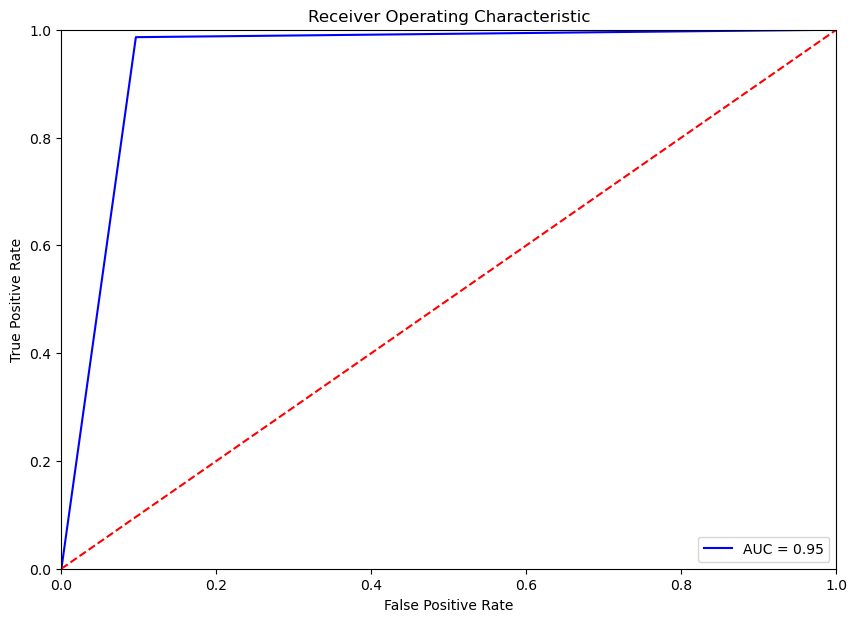

In [36]:
# Get and plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(np.array(predictions_formatted).flatten(), np.array(ground_truth_formatted).flatten())
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve.jpg', dpi=500)
plt.show()

In [37]:
def adapt_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

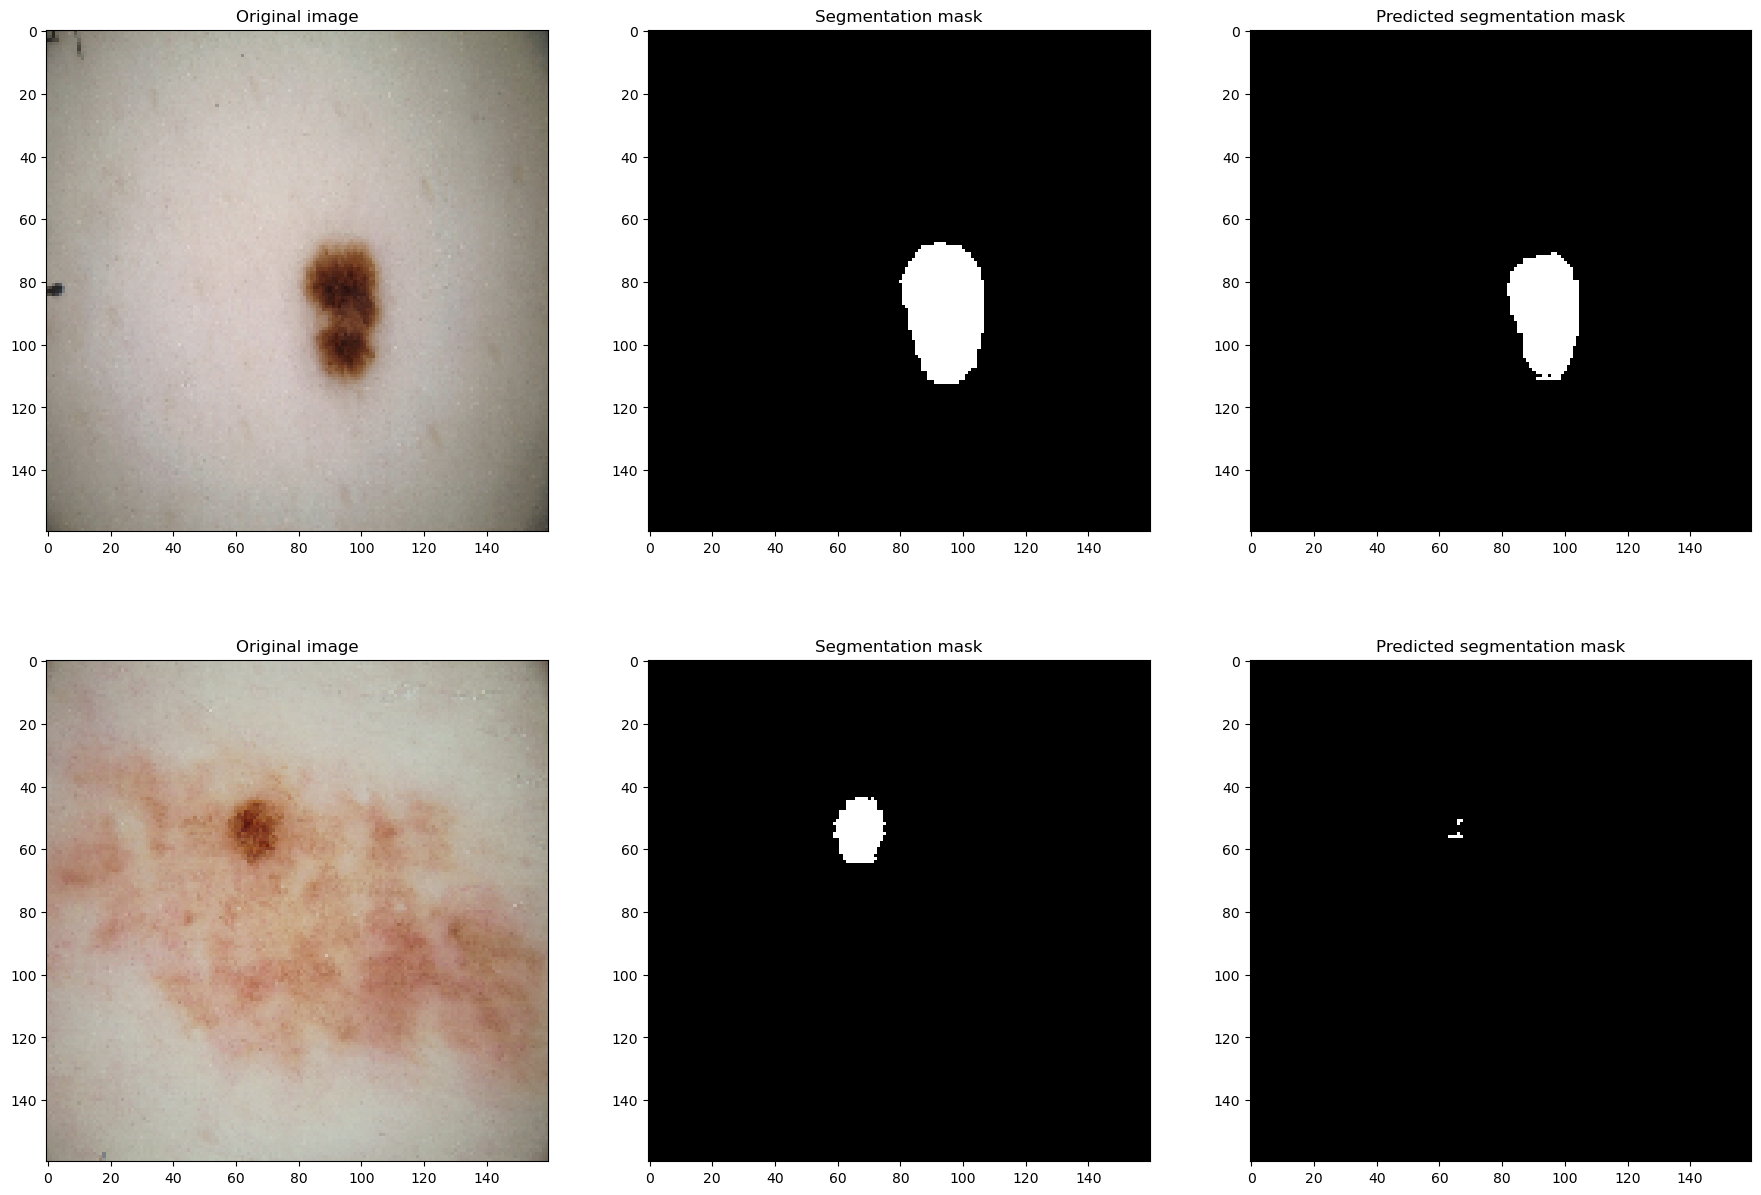

In [42]:
# Cetting values to rows and column variables
rows = 2
columns = 3

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))
row = 0

for i in [1, 7]:
    
    column = 0
    
    # Plot images
    axs[row, column].imshow(load_img(test_input_img_paths[i], target_size=img_size))
    axs[row, column].set_title("Original image")
    column+=1
    
    axs[row, column].imshow(load_img(test_target_img_paths[i],  target_size=img_size), cmap='gray')
    axs[row, column].set_title("Segmentation mask")
    column+=1
    
    axs[row, column].imshow(adapt_mask(i), cmap='gray')
    axs[row, column].set_title("Predicted segmentation mask")
    column+=1
    row+=1

plt.savefig('Predicted segmantation masks.jpg', dpi=300)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Flatten predictions and ground truth for evaluation
flat_predictions = np.array(predictions_formatted).flatten()
flat_ground_truth = np.array(ground_truth_formatted).flatten()

# Generate the classification report
report = classification_report(flat_ground_truth, flat_predictions, target_names=['No Lesion', 'Lesion'])
print("Classification Report:\n", report)

# You can also generate a confusion matrix
conf_matrix = confusion_matrix(flat_ground_truth, flat_predictions)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

   No Lesion       0.96      1.00      0.98    353672
      Lesion       0.99      0.72      0.83     55928

    accuracy                           0.96    409600
   macro avg       0.97      0.86      0.90    409600
weighted avg       0.96      0.96      0.96    409600

Confusion Matrix:
 [[353298    374]
 [ 15814  40114]]
